## Paquid Data Test

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
from lifelines import ExponentialFitter
from sklearn.neighbors import KernelDensity

from jmstate import MultiStateJointModel
import jmstate
from jmstate.typedefs import *
from jmstate.utils import *

In [15]:
paquid = pd.read_csv("data/paquid.csv")
print(paquid.head())

   ID  MMSE  BVRT   IST  HIER  CESD        age     agedem  dem  age_init  CEP  \
0   1  26.0  10.0  37.0   2.0  11.0  68.506300  68.506300    0   67.4167    1   
1   2  26.0  13.0  25.0   1.0  10.0  66.995400  85.616701    1   65.9167    1   
2   2  28.0  13.0  28.0   1.0  15.0  69.095300  85.616701    1   65.9167    1   
3   2  25.0  12.0  23.0   1.0  18.0  73.807200  85.616701    1   65.9167    1   
4   2  24.0  13.0  16.0   3.0  22.0  84.142368  85.616701    1   65.9167    1   

   male  
0     1  
1     0  
2     0  
3     0  
4     0  


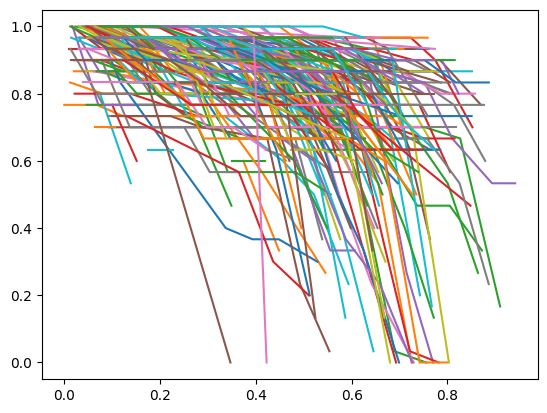

In [ ]:
def get_ages(id):
    T = []
    for k in range(4):
        mask = (paquid["ID"].values == id) & (paquid["HIER"].values == k)
        if sum(mask) > 0:
            T.append((min(paquid["age"][mask]), k))

    if len(T) <= 1:
        return T

    result = [T[0]]

    for i in range(1, len(T)):
        if T[i][0] >= result[-1][0]:
            result.append(T[i])

    return result


def last_non_nan(y: torch.Tensor) -> torch.Tensor:
    mask = ~torch.isnan(y).any(dim=2)  # shape (n_samples, n_timepoints)
    reversed_mask = mask.flip(dims=[1])
    last_idx_from_end = reversed_mask.double().cumsum(dim=1).argmax(dim=1)
    last_idx = y.shape[1] - 1 - last_idx_from_end
    # Gather the last valid values using advanced indexing
    return y[torch.arange(y.shape[0]), last_idx]


get_last_visit_age = lambda id: paquid[paquid["ID"] == id]["age"].max()
get_t = lambda id: torch.tensor(paquid[paquid["ID"] == id]["age"].values)
get_X = lambda id: torch.tensor(paquid[paquid["ID"] == id]["CEP"].min())
get_Y = lambda id: torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

ids = range(1, 501)
trajectories = [get_ages(id) for id in ids]
c = torch.tensor([get_last_visit_age(id) for id in ids]).view(-1, 1)
t = torch.nn.utils.rnn.pad_sequence(
    [get_t(id) for id in ids], batch_first=True, padding_value=torch.nan
)
x = torch.tensor([[get_X(id)] for id in ids])
y = torch.nn.utils.rnn.pad_sequence(
    [get_Y(id) for id in ids], batch_first=True, padding_value=torch.nan
)[..., None]

y = (y - torch.nanquantile(y, 0)) / (torch.nanquantile(y, 1) - torch.nanquantile(y, 0))
trajectories = [[(((m - torch.nanquantile(t, 0).item()) / (torch.nanquantile(t, 1) - torch.nanquantile(t, 0)).item()), s)  for (m, s) in trajectory] for trajectory in trajectories]
t = (t - torch.nanquantile(t, 0)) / (torch.nanquantile(t, 1) - torch.nanquantile(t, 0))

for j in range(1, y.size(-2)):
    y[:, j] = torch.minimum(y[:, j], y[:, j-1])


plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [17]:
buckets = build_buckets(trajectories)
print(buckets.keys())

dict_keys([(1, 3), (0, 1), (1, 2), (0, 2), (2, 3), (0, 3)])


In [18]:
surv_params = {}
for key, value in buckets.items():
    t0, t1 = value.t0, value.t1
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = exp_fit.lambda_

In [19]:
def f(gamma, x, b):
    psi = gamma + b
    psi[..., 1].exp_()
    psi2 = psi * torch.tensor([1, -1, 1])
    return psi2


surv = {
    key: (jmstate.functions.exponential(surv_params[key]), jmstate.functions.sigmoid)
    for key in buckets.keys()
}

init_gamma = torch.tensor([1, 1, 0.5])

init_alphas = {key: torch.zeros(1) for key in buckets.keys()}

init_betas = None

init_params = ModelParams(
    init_gamma,
    repr_from_cov(torch.eye(3), method="full"),
    repr_from_cov(torch.eye(1) / 10, method="ball"),
    init_alphas,
    init_betas,
)

model_design = ModelDesign(
    f,
    jmstate.functions.sigmoid,
    surv,
)

In [20]:
data = ModelData(None, t, y, trajectories, c)

Running joint model: 100%|██████████| 100/100 [00:22<00:00,  4.50it/s]
/home/flaplante/Documents/Application/jmstate-main(30)/jmstate-main/jmstate/model/_base.py:307: UserWarning: Error infering model parameters
  job.end(info, metrics)
/home/flaplante/Documents/Application/jmstate-main(30)/jmstate-main/jmstate/model/_base.py:307: UserWarning: The parameters are not converged, try increasing the maximum number of iterations, decreasing the learning rate, or increasing n_chains
  job.end(info, metrics)
Running joint model: 100%|██████████| 300/300 [00:41<00:00,  7.28it/s]


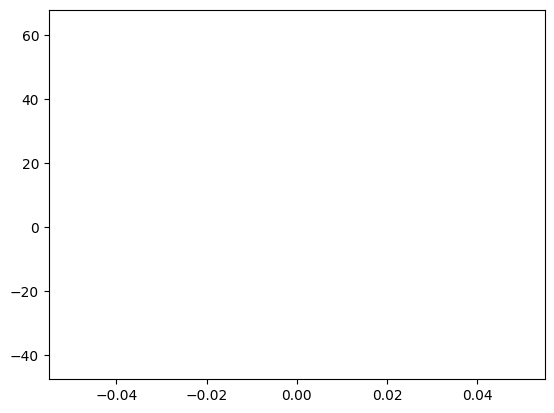

In [ ]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    jobs=[
        jmstate.jobs.DeterministicFit(torch.optim.LBFGS),
        jmstate.jobs.LogParamsHistory(),
        jmstate.jobs.GradStop()
    ],
    max_iterations=100
)
metrics = model.do(
    data,
    jobs=[
        jmstate.jobs.RandomFit(torch.optim.Rprop),
        jmstate.jobs.LogParamsHistory(),
        jmstate.jobs.GradStop()
    ],
    n_chains=10
)



plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [22]:
print(model.params_)

ModelParams(gamma=tensor([nan, nan, nan]), Q_repr=MatRepr(flat=tensor([nan, nan, nan, nan, nan, nan]), dim=3, method='full'), R_repr=MatRepr(flat=tensor([nan]), dim=1, method='ball'), alphas={(1, 3): tensor([nan]), (0, 1): tensor([nan]), (1, 2): tensor([nan]), (0, 2): tensor([nan]), (2, 3): tensor([nan]), (0, 3): tensor([nan])}, betas=None)


In [ ]:
n_test = 50
t_test = torch.linspace(0, 1, 15)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(3).double(), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1).double(), model.params_.get_cov("R")
)

x_test = KernelDensity().fit(x).sample(n_test)
b_test = Q_dist.sample((n_test,))
psi_test = f(model.params_.gamma, None, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]
y_test = model_design.regression_fn(t_test, psi_test).squeeze(0)
y_test += R_dist.sample(y_test.shape[:-1])
plt.plot(t_test.T, y_test[:, :, 0].T)
plt.show()

ValueError: Expected parameter covariance_matrix (Tensor of shape (3, 3)) of distribution MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]])